<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/CircuitosDigitais/blob/master/Replace_Missing_Values_Temperature%5BAracaju%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
aracajuData = pd.read_csv("https://raw.githubusercontent.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/master/DadosDiarios/aracajudiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
aracajuData["Data"] = pd.to_datetime(aracajuData["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
aracajuData.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,22441.0,22441.000000,11198.000000,11210.000000,10076.000000,10767.000000,6743.000000,11071.000000,11196.000000,9385.000000,0.0
mean,83096.0,599.492001,3.344731,29.388662,23.116485,7.837606,3.931915,26.381604,76.868502,2.762278,NaN
std,0.0,600.013154,9.240869,1.402776,1.429518,3.128315,1.309769,1.263401,5.708472,1.094090,NaN
min,83096.0,0.000000,0.000000,23.900000,11.000000,0.000000,0.000000,19.600000,44.250000,0.000000,NaN
25%,83096.0,0.000000,0.000000,28.300000,22.200000,6.200000,3.100000,25.520000,73.250000,2.200000,NaN
50%,83096.0,0.000000,0.000000,29.500000,23.300000,8.900000,4.000000,26.520000,76.500000,2.733333,NaN
75%,83096.0,1200.000000,2.500000,30.400000,24.100000,10.200000,4.700000,27.320000,80.000000,3.400000,NaN
max,83096.0,1200.000000,157.000000,35.300000,27.100000,12.500000,18.100000,29.920000,100.000000,6.900000,NaN


In [5]:
#Verificando dados
aracajuData.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,83096,1980-01-01,0,NaN,29.0,NaN,4.1,2.2,26.34,75.5,4.033333,NaN
1,83096,1980-01-01,1200,0.0,NaN,22.5,NaN,NaN,NaN,NaN,NaN,NaN
2,83096,1980-01-02,0,NaN,29.1,NaN,3.9,3.0,26.90,81.5,4.333333,NaN
3,83096,1980-01-02,1200,0.0,NaN,24.3,NaN,NaN,NaN,NaN,NaN,NaN
4,83096,1980-01-03,0,NaN,29.0,NaN,0.3,2.5,26.94,86.5,4.400000,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
aracajuData = aracajuData.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
aracajuData00, aracajuData12 = aracajuData[aracajuData["Hora"] == 0], aracajuData[aracajuData["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
aracajuData00, aracajuData12 = aracajuData00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), aracajuData12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
aracajuData00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,11210.000000,0.0,10767.000000,6743.000000,11071.000000,11196.000000,9385.000000
mean,NaN,29.388662,NaN,7.837606,3.931915,26.381604,76.868502,2.762278
std,NaN,1.402776,NaN,3.128315,1.309769,1.263401,5.708472,1.094090
min,NaN,23.900000,NaN,0.000000,0.000000,19.600000,44.250000,0.000000
25%,NaN,28.300000,NaN,6.200000,3.100000,25.520000,73.250000,2.200000
50%,NaN,29.500000,NaN,8.900000,4.000000,26.520000,76.500000,2.733333
75%,NaN,30.400000,NaN,10.200000,4.700000,27.320000,80.000000,3.400000
max,NaN,35.300000,NaN,12.500000,18.100000,29.920000,100.000000,6.900000


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
aracajuData12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,11198.000000,0.0,10076.000000,0.0,0.0,0.0,0.0,0.0
mean,3.344731,NaN,23.116485,NaN,NaN,NaN,NaN,NaN
std,9.240869,NaN,1.429518,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,11.000000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,22.200000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,23.300000,NaN,NaN,NaN,NaN,NaN
75%,2.500000,NaN,24.100000,NaN,NaN,NaN,NaN,NaN
max,157.000000,NaN,27.100000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
aracajuData00 = aracajuData00.drop(columns = ["Precipitacao","TempMinima"])
aracajuData12 = aracajuData12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
aracajuData00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,29.0,4.1,2.2,26.34,75.50,4.033333
1980-01-02,29.1,3.9,3.0,26.90,81.50,4.333333
1980-01-03,29.0,0.3,2.5,26.94,86.50,4.400000
1980-01-04,28.9,3.0,1.8,25.36,87.50,3.566667
1980-01-05,28.8,1.2,1.5,26.02,83.25,2.166667


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
aracajuData12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,0.0,22.5
1980-01-02,0.0,24.3
1980-01-03,0.0,25.2
1980-01-04,12.2,25.1
1980-01-05,8.2,21.9


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado 
dataSetProv = dataSetProv.join(aracajuData00).join(aracajuData12)

In [18]:
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,29.0,4.1,2.2,26.34,75.50,4.033333,0.0,22.5
1980-01-02,29.1,3.9,3.0,26.90,81.50,4.333333,0.0,24.3
1980-01-03,29.0,0.3,2.5,26.94,86.50,4.400000,0.0,25.2
1980-01-04,28.9,3.0,1.8,25.36,87.50,3.566667,12.2,25.1
1980-01-05,28.8,1.2,1.5,26.02,83.25,2.166667,8.2,21.9


In [19]:
len(dataSetProv)

13880

In [20]:
dataSetProv.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,11210.000000,10767.000000,6743.000000,11071.000000,11196.000000,9385.000000,11198.000000,10076.000000
mean,29.388662,7.837606,3.931915,26.381604,76.868502,2.762278,3.344731,23.116485
std,1.402776,3.128315,1.309769,1.263401,5.708472,1.094090,9.240869,1.429518
min,23.900000,0.000000,0.000000,19.600000,44.250000,0.000000,0.000000,11.000000
25%,28.300000,6.200000,3.100000,25.520000,73.250000,2.200000,0.000000,22.200000
50%,29.500000,8.900000,4.000000,26.520000,76.500000,2.733333,0.000000,23.300000
75%,30.400000,10.200000,4.700000,27.320000,80.000000,3.400000,2.500000,24.100000
max,35.300000,12.500000,18.100000,29.920000,100.000000,6.900000,157.000000,27.100000


In [0]:
aracajuData = dataSetProv

In [0]:
aracajuData["Mes"] = aracajuData.index.month

In [23]:
aracajuData.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima,Mes
count,11210.000000,10767.000000,6743.000000,11071.000000,11196.000000,9385.000000,11198.000000,10076.000000,13880.000000
mean,29.388662,7.837606,3.931915,26.381604,76.868502,2.762278,3.344731,23.116485,6.522767
std,1.402776,3.128315,1.309769,1.263401,5.708472,1.094090,9.240869,1.429518,3.448872
min,23.900000,0.000000,0.000000,19.600000,44.250000,0.000000,0.000000,11.000000,1.000000
25%,28.300000,6.200000,3.100000,25.520000,73.250000,2.200000,0.000000,22.200000,4.000000
50%,29.500000,8.900000,4.000000,26.520000,76.500000,2.733333,0.000000,23.300000,7.000000
75%,30.400000,10.200000,4.700000,27.320000,80.000000,3.400000,2.500000,24.100000,10.000000
max,35.300000,12.500000,18.100000,29.920000,100.000000,6.900000,157.000000,27.100000,12.000000


In [0]:
#Transformando a coluna Data de volta em uma coluna de informações do dataSet
aracajuData = aracajuData.reset_index(drop = True)

In [25]:
aracajuData.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima,Mes
0,29.0,4.1,2.2,26.34,75.50,4.033333,0.0,22.5,1
1,29.1,3.9,3.0,26.90,81.50,4.333333,0.0,24.3,1
2,29.0,0.3,2.5,26.94,86.50,4.400000,0.0,25.2,1
3,28.9,3.0,1.8,25.36,87.50,3.566667,12.2,25.1,1
4,28.8,1.2,1.5,26.02,83.25,2.166667,8.2,21.9,1


# Modelagem para previsão de Temperatura Máxima

In [0]:
dataTreino = aracajuData.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMaxAracaju = dataTreino["TempMaxima"]
dataTreino = dataTreino.drop(columns = "TempMaxima")

In [28]:
#Visualizando dados
dataTreino.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima,Mes
0,4.1,2.2,26.34,75.50,4.033333,0.0,22.5,1
1,3.9,3.0,26.90,81.50,4.333333,0.0,24.3,1
2,0.3,2.5,26.94,86.50,4.400000,0.0,25.2,1
3,3.0,1.8,25.36,87.50,3.566667,12.2,25.1,1
4,1.2,1.5,26.02,83.25,2.166667,8.2,21.9,1


In [29]:
tempMaxAracaju.head()

0    29.0
1    29.1
2    29.0
3    28.9
4    28.8
Name: TempMaxima, dtype: float64

In [0]:
colunas = dataTreino.columns

In [0]:
#Efetuando uma transformação robusta, trabalhando com os dados entre os percentis 10 e 90
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreino = mms.fit_transform(dataTreino)

In [32]:
prov = pd.DataFrame(dataTreino)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima,Mes
count,10749.000000,6733.000000,11064.000000,11183.000000,9365.000000,11178.000000,10065.000000,11210.000000
mean,0.254838,-0.565322,0.314089,0.170119,-0.198969,-0.957337,0.505041,0.000568
std,0.499799,0.144675,0.244769,0.204843,0.316555,0.117807,0.177576,0.627966
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.008000,-0.657459,0.147287,0.040359,-0.362319,-1.000000,0.391304,-0.454545
50%,0.424000,-0.558011,0.341085,0.156951,-0.207730,-1.000000,0.527950,-0.090909
75%,0.632000,-0.480663,0.496124,0.282511,-0.014493,-0.966879,0.627329,0.636364
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreino = np.nan_to_num(dataTreino, copy = False)

In [34]:
#Verificando dimensões do dataSet
print(dataTreino.shape)

(11210, 8)


In [0]:
#Separando conjunto de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(dataTreino, tempMaxAracaju, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 8, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
#Adicionando e alterando parâmetros neste dicionário, pode-se aumentar ou diminuir a quantidade de parâmetros a serem testados na modelagem
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [8]}

In [0]:
#Modelagem para buscar os melhores parâmetros
#Por limitações de poder de processamento, retirou-se o n_jobs = -1 dos parâmetros do Grid Search
grid_search = GridSearchCV(estimator = estimator, param_grid = parameters, n_jobs = -1,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [41]:
#Busca pelos melhores parâmetros
grid_result = grid_search.fit(X_train, Y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=8 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 635.0129 - mean_absolute_error: 25.0488
Epoch 2/200
 - 1s - loss: 341.9402 - mean_absolute_error: 18.3611
Epoch 3/200
 - 1s - loss: 172.2923 - mean_absolute_error: 12.9721
Epoch 4/200
 - 1s - loss: 74.6990 - mean_absolute_error: 8.4513
Epoch 5/200
 - 1s - loss: 26.1810 - mean_absolute_error: 4.8419
Epoch 6/200
 - 1s - loss: 7.4404 - mean_absolute_error: 2.3571
Epoch 7/200
 - 1s - loss: 2.6325 - mean_absolute_error: 1.3354
Epoch 8/200
 - 1s - loss: 1.9812 - mean_absolute_error: 1.1630
Epoch 9/200
 - 1s - loss: 1.9451 - mean_absolute_error: 1.1468
Epoch 10/200
 - 1s - loss: 1.9445 - mean_absolute_error: 1.1456
Epoch 11/200
 - 1s - loss: 

In [42]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.300569, usando {'batch_size': 10, 'camadas': 2, 'units': 8}
Resultados (Desvio padrão) {Parâmetros}
-0.300569 (0.020468) {'batch_size': 10, 'camadas': 2, 'units': 8}


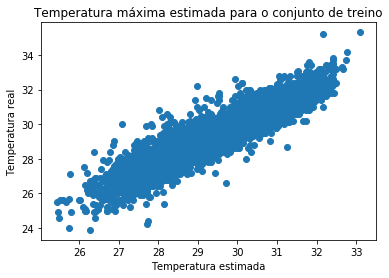

In [43]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_search.predict(X_train), Y_train)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(grid_search.predict(X_train), Y_train))

[[1.         0.93000198]
 [0.93000198 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_pred = grid_search.predict(X_test)

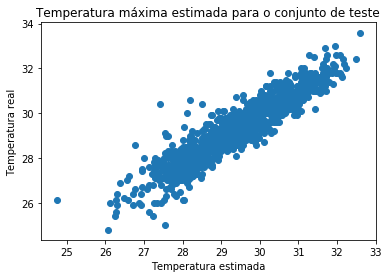

In [46]:
#Gráfico que mostra a relação entre ROP real e ROP previsto
plt.scatter(Y_pred, Y_test)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [47]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(Y_pred, Y_test))

[[1.         0.92686015]
 [0.92686015 1.        ]]


In [48]:
#Erro absoluto médio entre o ROP previsto e o real
print(mean_absolute_error(Y_test, Y_pred))

0.4205996286220363


In [49]:
#Erro quadrático médio entre o ROP previsto e o real
print(mean_squared_error(Y_test, Y_pred))

0.2998444893663342


# Modelagem para previsão de Temperatura Mínima

In [0]:
dataTreino = aracajuData.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMinAracaju = dataTreino["TempMinima"]
dataTreino = dataTreino.drop(columns = "TempMinima")

In [52]:
#Visualizando dados
dataTreino.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,Mes
0,29.0,4.1,2.2,26.34,75.50,4.033333,0.0,1
1,29.1,3.9,3.0,26.90,81.50,4.333333,0.0,1
2,29.0,0.3,2.5,26.94,86.50,4.400000,0.0,1
3,28.9,3.0,1.8,25.36,87.50,3.566667,12.2,1
4,28.8,1.2,1.5,26.02,83.25,2.166667,8.2,1


In [53]:
tempMinAracaju.head()

0    22.5
1    24.3
2    25.2
3    25.1
4    21.9
Name: TempMinima, dtype: float64

In [0]:
colunas = dataTreino.columns

In [0]:
#Efetuando uma transformação robusta, trabalhando com os dados entre os percentis 10 e 90
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreino = mms.fit_transform(dataTreino)

In [56]:
prov = pd.DataFrame(dataTreino)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,Mes
count,10065.000000,9640.000000,5693.000000,10060.000000,10062.000000,8351.000000,10063.000000,10076.000000
mean,-0.028563,0.258515,-0.557714,0.121098,0.162048,-0.237118,-0.958621,0.006821
std,0.245876,0.498970,0.145485,0.301199,0.207159,0.316200,0.115539,0.628227
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.210526,0.008000,-0.646409,-0.094527,0.031390,-0.385366,-1.000000,-0.454545
50%,-0.017544,0.424000,-0.558011,0.149254,0.147982,-0.258537,-1.000000,0.090909
75%,0.140351,0.632000,-0.469613,0.343284,0.282511,-0.053659,-0.969427,0.636364
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreino = np.nan_to_num(dataTreino, copy = False)

In [58]:
#Verificando dimensões do dataSet
print(dataTreino.shape)

(10076, 8)


In [0]:
#Separando conjunto de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(dataTreino, tempMinAracaju, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
#Adicionando e alterando parâmetros neste dicionário, pode-se aumentar ou diminuir a quantidade de parâmetros a serem testados na modelagem
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [8]}

In [0]:
#Modelagem para buscar os melhores parâmetros
#Por limitações de poder de processamento, retirou-se o n_jobs = -1 dos parâmetros do Grid Search
grid_search = GridSearchCV(estimator = estimator, param_grid = parameters, n_jobs = -1,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [64]:
#Busca pelos melhores parâmetros
grid_result = grid_search.fit(X_train, Y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=8 ...............................
Epoch 1/200
 - 1s - loss: 373.4987 - mean_absolute_error: 19.1451
Epoch 2/200
 - 1s - loss: 176.7125 - mean_absolute_error: 13.1363
Epoch 3/200
 - 1s - loss: 76.9389 - mean_absolute_error: 8.5753
Epoch 4/200
 - 1s - loss: 27.8581 - mean_absolute_error: 5.0144
Epoch 5/200
 - 1s - loss: 8.4176 - mean_absolute_error: 2.5777
Epoch 6/200
 - 1s - loss: 2.9984 - mean_absolute_error: 1.4504
Epoch 7/200
 - 1s - loss: 2.1126 - mean_absolute_error: 1.1672
Epoch 8/200
 - 1s - loss: 2.0416 - mean_absolute_error: 1.1307
Epoch 9/200
 - 1s - loss: 2.0394 - mean_absolute_error: 1.1263
Epoch 10/200
 - 1s - loss: 2.0396 - mean_absolute_error: 1.1263
Epoch 11/200
 - 1s - loss: 2.0405 - mean_absolute_error: 1.1269
Epoch 12/200
 - 1s - loss: 2.0403 - mean_absolute_error: 1.1269
Epoch 13/200
 - 1s - l

In [65]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.654367, usando {'batch_size': 10, 'camadas': 2, 'units': 8}
Resultados (Desvio padrão) {Parâmetros}
-0.654367 (0.022512) {'batch_size': 10, 'camadas': 2, 'units': 8}


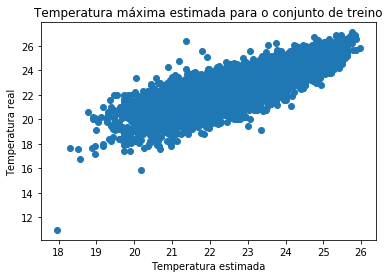

In [66]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_search.predict(X_train), Y_train)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(grid_search.predict(X_train), Y_train))

[[1.         0.83418343]
 [0.83418343 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_pred = grid_search.predict(X_test)

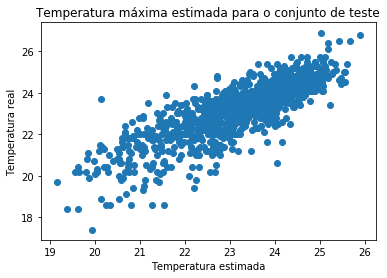

In [69]:
#Gráfico que mostra a relação entre ROP real e ROP previsto
plt.scatter(Y_pred, Y_test)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [70]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(Y_pred, Y_test))

[[1.         0.82504198]
 [0.82504198 1.        ]]


In [71]:
#Erro absoluto médio entre o ROP previsto e o real
print(mean_absolute_error(Y_test, Y_pred))

0.6106622097984193


In [72]:
#Erro quadrático médio entre o ROP previsto e o real
print(mean_squared_error(Y_test, Y_pred))

0.6315251421822906
